In [10]:
import os
from collections import defaultdict
import numpy as np

log_dir = './logs'
experiment_logs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for filename in os.listdir(log_dir):
    if filename.endswith('.log'):
        parts = filename.split('-')
        method = '-'.join(parts[0:1])
        experiment_name = '-'.join(parts[1:2])
        dataset = '-'.join(parts[2:3])
        if method == "Auncel":
            k = int('-'.join(parts[3:4]))
            error = float(parts[4:5][0][:-4])
            if dataset == "bert":
                nlist = 128
            else:
                nlist = 1024
        else:
            nlist = '-'.join(parts[3:4])
            k = int('-'.join(parts[4:5]))
            if method == "ConANN":
                error = float(parts[5:6][0])
            else:
                error = float(parts[5:6][0][:-4])

        with open(os.path.join(log_dir, filename), 'r') as file:
            experiment_logs[experiment_name][method][dataset][k][error] = [float(line.strip()) for line in file.readlines()]

datasets = [j for j in experiment_logs['efficiency']['ConANN'].keys()]
print(datasets)

data = experiment_logs['error']['ConANN']['bert'][100][0.1]
average = np.mean(data)
print(average)

data = experiment_logs['error']['Auncel']['deep10M'][100][0.1]
average = np.mean(data)
print(average)

['gist', 'sift1M', 'deep10M', 'bert', 'fasttext']
0.10546579307860263
0.00292199903


In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Parameters to filter
experiment_name = 'latency'  # Assuming the experiment name is 'efficiency'
k_value = 100
error_value = 0.2
target_dataset = 'glove'  # Filter for this dataset
# target_dataset = 'deep10M' 

# Extract data for the CDF
data = {}

for method in experiment_logs[experiment_name]:
    for dataset in experiment_logs[experiment_name][method]:
        if dataset == target_dataset:  # Only process the target dataset
            try:
                values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                data[method] = np.sort(values)  # Sort values for CDF calculation
            except KeyError:
                continue
                
for method, values in data.items():
    avg_latency = np.mean(values)
    print(f"Average latency for {method}: {avg_latency}")
    
# # Plotting the CDFs
# fig, ax = plt.subplots(figsize=(5, 2))

# # Plot CDF for each method
# for method, values in data.items():
#     # Calculate CDF
#     cdf = np.arange(1, len(values) + 1) / len(values)
#     ax.plot(values, cdf, label=method, linewidth=3)

# # Customize plot
# ax.set_title(f"Latency CDF for BERT (k={k_value}, α={error_value})")
# ax.set_xlabel('Latency (ms)')
# ax.set_ylabel('CDF')
# ax.legend(loc='upper left') #, bbox_to_anchor=(1, 1))
# ax.grid(True)

# # plt.tight_layout()
# plt.savefig(f'latency-bert-{k_value}-{error_value}.pdf')
# plt.show()

Average latency for ConANN: 11.359472331585845
Average latency for Faiss: 10.618609285


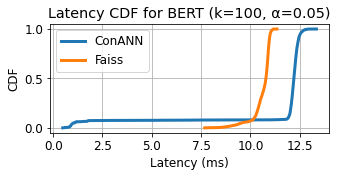

In [137]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Parameters to filter
experiment_name = 'latency'  # Assuming the experiment name is 'efficiency'
k_value = 100
error_value = 0.05
target_dataset = 'bert_100'  # Filter for this dataset
# target_dataset = 'deep10M' 

# Extract data for the CDF
data = {}

for method in experiment_logs[experiment_name]:
    for dataset in experiment_logs[experiment_name][method]:
        if dataset == target_dataset:  # Only process the target dataset
            try:
                values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                data[method] = np.sort(values)  # Sort values for CDF calculation
            except KeyError:
                continue
                
for method, values in data.items():
    avg_latency = np.mean(values)
    print(f"Average latency for {method}: {avg_latency}")
    
# Plotting the CDFs
fig, ax = plt.subplots(figsize=(5, 2))

# Plot CDF for each method
for method, values in data.items():
    # Calculate CDF
    cdf = np.arange(1, len(values) + 1) / len(values)
    ax.plot(values, cdf, label=method, linewidth=3)

# Customize plot
ax.set_title(f"Latency CDF for BERT (k={k_value}, α={error_value})")
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('CDF')
ax.legend(loc='upper left') #, bbox_to_anchor=(1, 1))
ax.grid(True)

# plt.tight_layout()
plt.savefig(f'latency-bert-{k_value}-{error_value}.pdf')
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# error_values = [0.05, 0.1, 0.2]
error_values = [0.1]
dataset = "deep10M"
k = 100

for error in error_values:
    print(f"\nError = {error}")
    
    # Step 1: Find Faiss clusters from the "efficiency" experiment
    faiss_clusters = experiment_logs['efficiency']['Faiss'][dataset][k][error]
    
    print(f"Clusters searched by FAISS: {faiss_clusters[0]}")
    
    # Step 2: Get IDs of methods where the clusters match Faiss
    matching_ids = {}
    for method in experiment_logs['efficiency']:
        if method != 'Faiss':  # Skip Faiss since we already have its clusters
            matching_ids[method] = []
            for idx, cluster in enumerate(experiment_logs['efficiency'][method][dataset][k][error]):
                if cluster == faiss_clusters[0]:  # match Faiss clusters
                    matching_ids[method].append(idx)

    # Step 3: Extract corresponding latency values from the "latency" experiment for other methods
    latency_values = {'Faiss': []}
    for idx, latency in enumerate(experiment_logs['latency']['Faiss'][dataset][k][error]):
        latency_values['Faiss'].append(latency)

    for method, ids in matching_ids.items():
        latency_values[method] = [experiment_logs['latency'][method][dataset][k][error][idx] for idx in ids]
        print(f"Method {method}; relevant queries {len(latency_values[method])}")

    # Step 4: Calculate average latencies and plot the difference
    avg_latency = {method: np.mean(latencies) for method, latencies in latency_values.items()}

    # Print average latency for Faiss and other methods
    for method, avg in avg_latency.items():
        print(f"{method}: Average Latency = {avg}")
        
    if 'ConANN' in avg_latency:
        faiss_avg = avg_latency['Faiss']
        conann_avg = avg_latency['ConANN']
        increase_percentage = ((conann_avg - faiss_avg) / faiss_avg) * 100
        print(f"ConANN: Latency Increase = {increase_percentage:.2f}%")


Error = 0.1
Clusters searched by FAISS: 11.0
Method ConANN; relevant queries 92
Faiss: Average Latency = 4.7795980049999995
ConANN: Average Latency = 273.4698871304348
ConANN: Latency Increase = 5621.61%


## Efficiency 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters to filter
experiment_name = 'efficiency'
k_value = 100
error_value = 0.1
target_datasets = ['bert', 'fasttext', 'sift1M', 'deep10M', 'gist']

# Extract data for the CDF
fig, axes = plt.subplots(1, len(target_datasets), figsize=(13, 1.8), sharey=True)
data = {}

colors = {"ConANN": "blue", "Faiss": "green"}

for idx, target_dataset in enumerate(target_datasets):
    data.clear()
    for method in experiment_logs[experiment_name]:
        for dataset in experiment_logs[experiment_name][method]:
            if dataset == target_dataset:
                try:
                    values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                    if method == 'ConANN':
                        count_minus_one = values.count(-1)
                        values = [v + 1 for v in values if v != -1]
                        print("Abstention rate ConANN:", count_minus_one)  # Output the count of -1 values
                    if method == 'Faiss':
                        values = values * 5000
                    data[method] = np.sort(values)
                except KeyError:
                    continue
    
    for method, values in data.items():
        avg_clusters = np.mean(values)
        print(f"Average number of clusters searched for {method} on {target_dataset}: {avg_clusters}")
    
    # Plot CDF for each method
    ax = axes[idx]
    for method, values in data.items():
        cdf = np.arange(1, len(values) + 1) / len(values)
        ax.plot(values, cdf, label=method, linewidth=2) #, color=colors[method])
    
    ax.set_title(f'{target_dataset}')
    ax.grid(True)

axes[0].set_ylabel('CDF')
# fig.suptitle(f'Number of clusters searched per query (k={k_value}, α={error_value})')
axes[4].legend(data.keys(), loc='lower right')
axes[2].set_xlabel('Clusters Searched')
plt.tight_layout()
plt.savefig(f'adaptivity-{k_value}-{error_value}.pdf')
# plt.show()

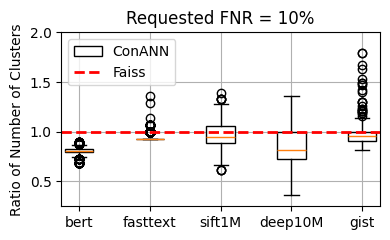

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) 
experiment_name = 'efficiency'
k_value = 100
error_value = 0.1  # Single error value
target_datasets = ['bert', 'fasttext', 'sift1M', 'deep10M', 'gist']
methods = ['ConANN', 'Faiss']

fig, ax = plt.subplots(figsize=(4, 2.5))

data_to_plot = {dataset: {'ConANN': [], 'Faiss': []} for dataset in target_datasets}
faiss_baselines = {}  # To store Faiss values for ratio calculation

for target_dataset in target_datasets:
    for method in methods:
        try:
            values = experiment_logs[experiment_name][method][target_dataset][k_value][error_value]
            data_to_plot[target_dataset][method] = values
            if method == 'Faiss' and len(values) > 0:
                faiss_baselines[target_dataset] = np.median(values)  # Store median Faiss value
        except KeyError:
            continue

# Prepare data for boxplots; ConANN values will be ratios to Faiss
boxplot_data = []
positions = []
labels = []
pos = 1

for dataset in target_datasets:
    conann_values = data_to_plot[dataset]['ConANN']
    faiss_values = data_to_plot[dataset]['Faiss']
    
    if len(conann_values) > 0 or len(faiss_values) > 0:
        if len(conann_values) > 0 and dataset in faiss_baselines:
            faiss_baseline = faiss_baselines[dataset]
            conann_ratios = [v / faiss_baseline for v in conann_values]
            boxplot_data.append(conann_ratios)
            positions.append(pos)
            labels.append('ConANN')
            pos += 1
        if len(faiss_values) > 0:
            # Faiss will be represented as a horizontal line at y=1
            pass
        pos += 1

if boxplot_data:
    box = ax.boxplot(boxplot_data, positions=positions, patch_artist=True, widths=0.8)
    for patch in box['boxes']:
        patch.set_facecolor('white')

ax.axhline(y=1, color='red', linestyle='--', linewidth=2)

dataset_positions = []
dataset_labels = []
current_pos = 1
for dataset in target_datasets:
    conann_count = len(data_to_plot[dataset]['ConANN'])
    faiss_count = len(data_to_plot[dataset]['Faiss'])
    if conann_count > 0 or faiss_count > 0:
        if conann_count > 0:
            dataset_positions.append(current_pos)
            current_pos += 2
        else:
            dataset_positions.append(current_pos)
            current_pos += 2
        dataset_labels.append(dataset)

ax.set_xticks(dataset_positions)
ax.set_xticklabels(dataset_labels)

ax.set_title(f'Requested FNR = {int(error_value * 100)}%')
ax.grid(True)
ax.set_ylim(0.25, 2) 

from matplotlib.patches import Patch
from matplotlib.lines import Line2D 
legend_elements = [
        Patch(facecolor='white', edgecolor='black', linewidth=1.0, label='ConANN'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Faiss')
]
ax.legend(handles=legend_elements, loc='upper left')

ax.set_ylabel('Ratio of Number of Clusters')
plt.tight_layout()
plt.savefig(f'adaptivity-k={k_value}-error-{error_value}.pdf', format='pdf')
plt.show()